In [1]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import pickle
import text_classifier as text_clf
import sys
sys.path.append("..")
import common
import importlib
importlib.reload(common)


<module 'common' from '..\\common.py'>

In [2]:
news_train, news_test = common.load_data('news')
spam_train, spam_test = common.load_data('spam')

In [3]:
def cross_validate(X, y, k, dims, num_epochs=5, ngrams=3):
    kf = KFold(k)
    results = {D: [] for D in dims}

    for D in dims:
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            clf = text_clf.TextClassifier(X_train, y_train, embed_dim=D, ngrams=ngrams, num_epochs=num_epochs)

            predictions = [clf.predict(text) for text in X_val]
            acc = (predictions == y_val).sum() / y_val.shape[0]
            results[D].append(acc)
    results = {D: np.mean(accs) for D, accs in results.items()}
    return results

In [4]:
# WARNING: TAKES LITERALlY FOREVER TO RUN FOR NEWS 

#ngrams = [1,2,3] 
#for n in ngrams:
#    accuracies = cross_validate(spam_train['texts'], spam_train['labels'], k=5, dims=range(1,50,4), ngrams=n)
#    pickle.dump(accuracies, open(f'spam_accs_{n}grams.p', 'wb'))

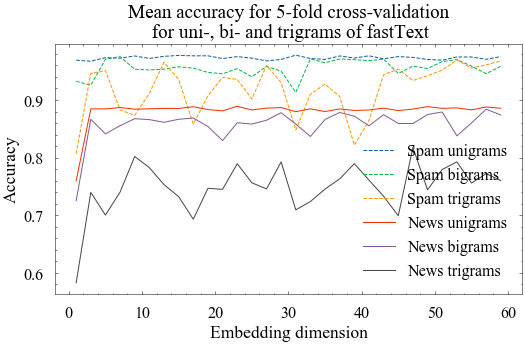

In [25]:
plt.style.use(['seaborn-poster', 'science', 'no-latex'])

plt.figure(figsize=(7.5,5))
spam_acc_files = [f"CV/spam_acc_all_{n}grams.p" for n in [1,2,3]]
spam_acc_data = [pickle.load(open(file, 'rb')) for file in spam_acc_files]
for data, label in zip(spam_acc_data, ["unigrams", "bigrams", "trigrams"]):
    plt.plot(list(data.keys()), list(data.values()), '--', label=f"Spam {label}")

news_acc_files = [f"CV/news_acc_all_{n}grams.p" for n in [1,2,3]]
news_acc_data = [pickle.load(open(file, 'rb')) for file in news_acc_files]
for data, label in zip(news_acc_data, ["unigrams", "bigrams", "trigrams"]):
    plt.plot(list(data.keys()), list(data.values()), '-', label=f"News {label}")

plt.legend()
plt.xlabel('Embedding dimension')
plt.ylabel('Accuracy')
plt.title('Mean accuracy for 5-fold cross-validation\n for uni-, bi- and trigrams of fastText')
plt.tight_layout()
plt.savefig("val_accs.pdf", bbox_inches='tight')

Train and save classifier to avoid re-training

switch `train` to `True` if the `*_fasttext_classifiers.p`'s havn't been trained and `pickle.dump`'ed
This is done to prevent training the classifier every time
news_fasttext_classifier.p should be around 570mb

In [4]:
train = False
load_classifiers = False
# optimal dimension found in cross val
spam_dim = 31
news_dim = 23

In [5]:
# load or train the classifier
if train and load_classifiers:
    spam_clf = text_clf.TextClassifier(spam_train['texts'], spam_train['labels'], embed_dim=spam_dim, ngrams=1)
    pickle.dump(spam_clf, open('spam_fasttext_classifier.p', 'wb'))
else:
    spam_clf = pickle.load(open('spam_fasttext_classifier.p', 'rb'))

In [6]:
# get the classification accuracy
spam_acc = accuracy_score(spam_test['labels'], [spam_clf.predict(text) for text in spam_test['texts']])
print(f'Test accuracy for spam: {round(spam_acc,3)}')

Test accuracy for spam: 0.972


In [7]:
if train:
    spam_train_emb = common.get_train_emb(X_train=spam_train['texts'], embedding=spam_clf.get_text_embedding, embed_dim=spam_dim)
    pickle.dump(spam_train_emb, open('spam_train_emb.p', 'wb'))
else:
    spam_train_emb = pickle.load(open('spam_train_emb.p', 'rb'))

In [8]:
if train and load_classifiers:
    news_clf = text_clf.TextClassifier(news_train['texts'], news_train['labels'], embed_dim=news_dim, ngrams=1)
    pickle.dump(news_clf, open('news_fasttext_classifier.p', 'wb'))
else:
    news_clf = pickle.load(open('news_fasttext_classifier.p', 'rb'))

In [9]:
news_acc = accuracy_score(news_test['labels'], [news_clf.predict(text) for text in news_test['texts']])
print(f'Test accuracy for news: {round(news_acc,2)}')

Test accuracy for news: 0.91


In [10]:
if train:
    news_train_emb = common.get_train_emb(news_train['texts'], news_clf.get_text_embedding, embed_dim=news_dim)
    pickle.dump(news_train_emb, open('news_train_emb.p', 'wb'))
else:
    news_train_emb = pickle.load(open('news_train_emb.p', 'rb'))

## PCA on spam

In [11]:
spam_pca = common.pca(spam_train_emb)

<Figure size 360x360 with 0 Axes>

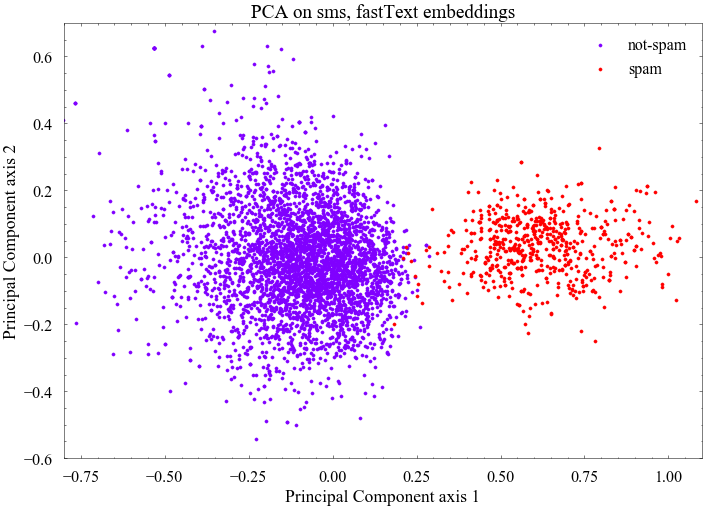

In [29]:
plt.figure(figsize=(5,5))
common.plot_pca(spam_pca, spam_train['labels'], [0,2], None)
plt.tight_layout()
plt.title("PCA on sms, fastText embeddings")
plt.xlim(-0.8,1.1)
plt.ylim(-0.6,0.7)
plt.savefig("PCAspamfast.pdf")
plt.show()

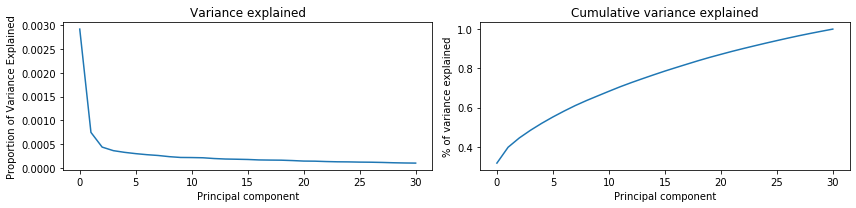

In [13]:
common.pca_variance_plots(spam_pca[0])
# we de see a relatively low explained variance with fastText for some reason even with the better separation

## PCA on news

In [14]:
news_pca = common.pca(news_train_emb)

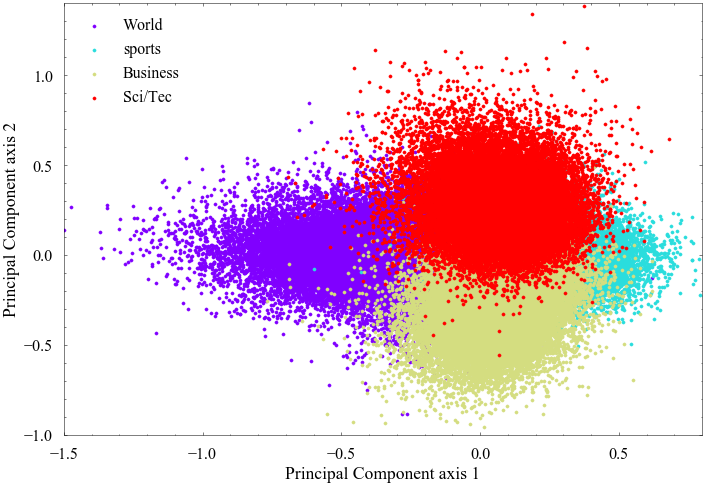

In [28]:
common.plot_pca(news_pca, news_train['labels'], [1,3])
plt.tight_layout()
plt.xlim(-1.5,0.8)
plt.ylim(-1,1.4)
plt.savefig("PCAnewsfast.pdf")
plt.show()

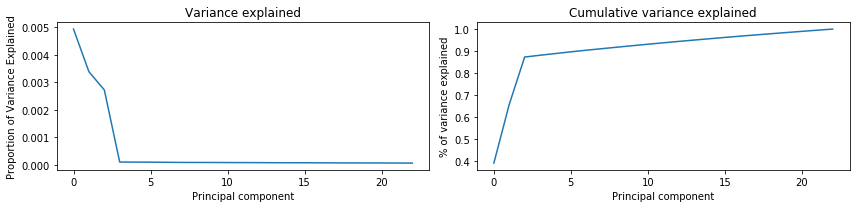

In [16]:
common.pca_variance_plots(eigenValues=news_pca[0])
# the explained variance behaves in a weird manner

## Investigate which words and n-grams that are strong predictors for spam and non-spam.

In [17]:
def ngrams(text, n):
    gram = []
    N = len(text.split())
    for i in range(0, N-n+1, n-1 if n>1 else 1):
        gram.append(text.split()[i:i+n])
    return [' '.join(x) for x in gram]

# iterate over all possible n-grams
def all_ngrams(texts, n):
    all_ngrams = []
    for ngram_list in [ngrams(text, n) for text in spam_train['texts']]:
        for ngram in ngram_list:
            all_ngrams.append(ngram)
    return set(all_ngrams)
# get the probalities
def ngram_probs(ngrams):
    probs = {}
    for ngram in ngrams:
        try:
            probs[ngram] = spam_clf.predict(ngram, return_prob=True)
        except:
            pass
    return probs
# ranking the probabilites with the scores from the classifier
def sorted_probs(ngram_probs, sort_for=0, top=10):
    """
    sort_for: 0 = not spam, 1 = spam
    """
    return np.array(sorted(ngram_probs.items(), key=lambda x: x[1][0][sort_for], reverse=True)[:top])[:,0]

In [18]:
unigrams = all_ngrams(spam_train['texts'], 1)
bigrams = all_ngrams(spam_train['texts'], 2)
trigrams = all_ngrams(spam_train['texts'], 3)

In [19]:
unigram_probs = ngram_probs(unigrams)
bigram_probs = ngram_probs(bigrams)
trigram_probs = ngram_probs(trigrams)

In [20]:
sorted_probs(trigram_probs, sort_for=0, top=10)

array(['i had it', 'up to me', 'shall i eat?', 'after &lt;#&gt; so',
       'me b4 he', 'amt. &lt;#&gt; lacs..thats', 'i still avent',
       'big difference. &lt;#&gt;', 'hey no i', 'then she buying'],
      dtype=object)

## Consider some of the texts that are classified as being spam. Can you add another sentence to it such that it becomes non-spam?

In [30]:
from tqdm import tqdm

In [31]:
actual_accs = {}
random_accs = {}

for n in tqdm(range(5,101,5)):
    actual_accs[n], random_accs[n] = [], []
    for _ in range(100):
        n_samples = 100
        random_spam = np.random.choice(spam_train['texts'][spam_train['labels'] == 1], n_samples)
        random_ngram = np.random.choice(list(all_ngrams(spam_train['texts'], n)))
        actual_acc = np.array([spam_clf.predict(spam) for spam in random_spam]).sum() / n_samples
        random_acc = np.array([spam_clf.predict(f"{spam} {random_ngram}") for spam in random_spam]).sum() / n_samples

        actual_accs[n].append(actual_acc)
        random_accs[n].append(random_acc)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:00<00:00, 12.05s/it]


In [32]:
mean_actual_accs = {n: np.mean(accs) for n, accs in actual_accs.items()}
mean_random_accs = {n: np.mean(accs) for n, accs in random_accs.items()}

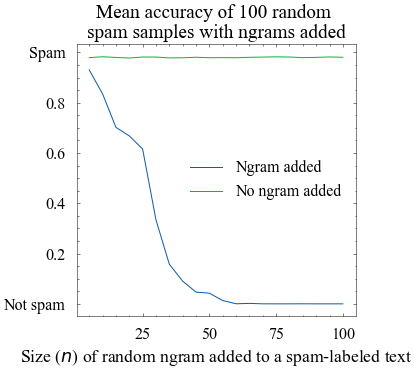

In [152]:
plt.figure(figsize=(5,5))
plt.plot(list(mean_random_accs.keys()), list(mean_random_accs.values()), label='Ngram added')
plt.plot(list(mean_actual_accs.keys()), list(mean_actual_accs.values()), label='No ngram added')
plt.xlabel('Size ($n$) of random ngram added to a spam-labeled text')
# plt.ylabel('fastText accuracy')
plt.title('Mean accuracy of 100 random \nspam samples with ngrams added')
plt.yticks(np.linspace(0,1,6), ['Not spam', 0.2, 0.4, 0.6, 0.8, 'Spam'])
plt.legend()
plt.show()

## Is this spam classifier useful for filtering e-mails?

no

In [30]:
emails = common.load_emails("../emails.csv")
emails_acc = accuracy_score(emails['labels'],
                            [spam_clf.predict(text) for text in emails['texts']])
print(f'Test accuracy for emails: {round(emails_acc,3)}')

Test accuracy for emails: 0.682
